<a href="https://colab.research.google.com/github/esorq/ml-portfolio/prjects/classification/Efficient_Pneumonia_Detection_in_Chest_Xray_Images_Using_Deep_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Efficient Pneumonia Detection in Chest Xray Images Using Deep Transfer Learning
**Abstract**

Pneumonia causes the death of around 700,000 children every year and affects 7% of the global population. Chest X-rays are primarily used for the diagnosis of this disease. However, even for a trained radiologist, it is a challenging task to examine chest X-rays. There is a need to improve the diagnosis accuracy. In this work, an efficient model for the detection of pneumonia trained on digital chest X-ray images is proposed, which could aid the radiologists in their decision making process

**Introduction**

Transfer learning is the reuse of a pre-trained model on a new problem.

This notebook leveregas this powerful technique and we take advantage of allready learned patterns from previous projects.

The dataset used in this project is a chest xray dataset consisitng of 219 images. Each image belonging to one out of two classes. Classes are "PNEUMONIA" or "NORMAL". 

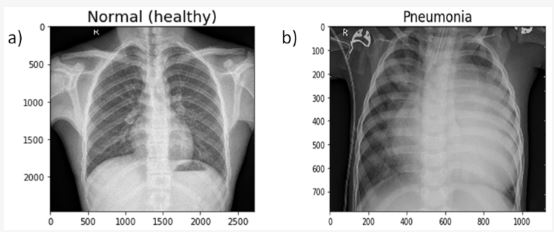

Content of the notebook:
-------
0. Set up
1. Get data
2. Turn data into datasets and dataloaders
3. Pick model with pre-trained weights
  31.  *Freeze backbone*
  32.  *Change output size*
4. Re-train model
5. Evaluate model   
6. Test predcition performance

## 0.Getting set up

In [1]:
# Starting off with some regular imports of libraries and scripts
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the scripts from scripts directory, download it from GitHub if it doesn't work
try:
    from scripts import data_actions, model_actions
except:
    # Get the scripts needed for this project
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/esorq/ml-portfolio
    !mv ml-portfolio/notebooks/scripts .
    !rm -rf ml-portfolio
    from scripts import data_actions, model_actions, viz_actions

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'ml-portfolio'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 261 (delta 72), reused 2 (delta 2), pack-reused 124
Receiving objects: 100% (261/261), 27.40 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [2]:
# Setup device agnostic code so that we can assign all objects to the same device
# PyTorch cannot handle the interaction betweeen objects that are saved on different devices.
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

In [3]:
import os
import zipfile
from pathlib import Path
import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Pneumonia"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
    
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "Pneumonia.zip", "wb") as f:
        request = requests.get("https://github.com/esorq/ml-portfolio/raw/main/data/Pneumonia.zip")
        print("Downloading Pneumonia...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "Pneumonia.zip", "r") as zip_ref:
        print("Unzipping Pneumonia data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "Pneumonia.zip")

Did not find data/Pneumonia directory, creating one...
Unzipping Pneumonia data...


In [4]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/Pneumonia/train'), PosixPath('data/Pneumonia/test'))

### 1.1 Check some samples

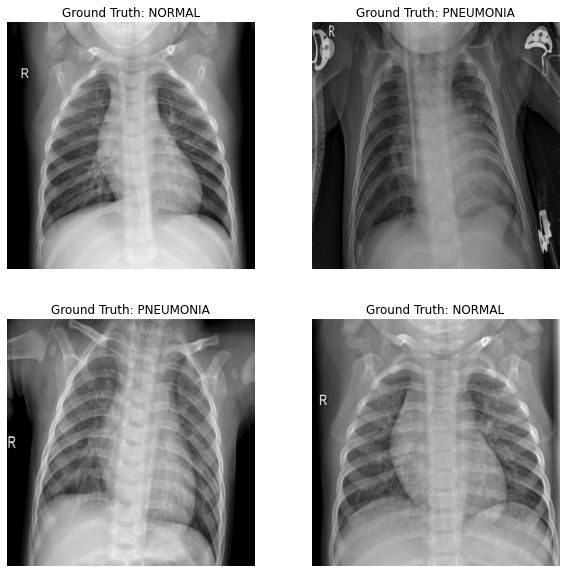

In [5]:
# Get a random list of image paths from train set and plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

num_images_to_plot = 4
test_image_path_list = list(Path(train_dir).glob("*/*.jpg")) # get list all image paths from train data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the train image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to plot

plt.figure(figsize=(10,10))
for i in range(len(test_image_path_sample)):
  img = mpimg.imread(test_image_path_sample[i])
  
  plt.subplot(2,2,i+1)
  plt.axis(False)
  plt.imshow(img)
  plt.title(f"Ground Truth: {os.path.basename(os.path.normpath(test_image_path_sample[i].parents[0]))}")

## 2. Turn data into datasets and dataloaders

PyTorch offers a variety of pre-trained models for different ML-tasks which can be found: https://pytorch.org/vision/stable/models.html

We pick Effifientnet_b0 because it is a small yet powerful model.

In [6]:
# First we get the weights of the model we intend to use for the projects
# By doing this we can get the transform needed to to transform the data in the correct way so that it fits the model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_actions.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) 

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fe666936970>,
 ['NORMAL', 'PNEUMONIA'])

## 3. Import pre-trained model

PyTorch offers a variety of pre-trained models for different ML-tasks which can be found: https://pytorch.org/vision/stable/models.html

We pick Effifientnet_b0 because it is a small yet powerful model. Other "heavier" models cna be used to improve performance

In [9]:
# Pick a model with pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [10]:
# Print a summary using torchinfo
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.1 Freeze backbone / base layers

In transfer learning is it common to just re-train the last classification layers. To do that we turn of trainability of base layers by setting .requires_grad = False 

In [11]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
# Print a summary using torchinfo 
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 3.2 Adapt the amount of output features

We need to change the number of classes since we now only have 2 classes instead of the 1000 classes used in the prior training of the model.

In [13]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

## 4. Train the model

For tarining we run the model_actions.train frunction which can be found in the importd scripts.

In [15]:
# Defining a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer. The timer is used to track how lonf the training takes.
from timeit import default_timer as timer 
start_time = timer()

# Using imported script functions for training and save the results
results, y_preds, y_tests = model_actions.train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6713 | train_acc: 0.5694 | test_loss: 0.5979 | test_acc: 0.6944
Epoch: 2 | train_loss: 0.5537 | train_acc: 0.7720 | test_loss: 0.5469 | test_acc: 0.7500
Epoch: 3 | train_loss: 0.4679 | train_acc: 0.8825 | test_loss: 0.5109 | test_acc: 0.7743
Epoch: 4 | train_loss: 0.4063 | train_acc: 0.9010 | test_loss: 0.4879 | test_acc: 0.7986
Epoch: 5 | train_loss: 0.3999 | train_acc: 0.8432 | test_loss: 0.4709 | test_acc: 0.7743
Epoch: 6 | train_loss: 0.3748 | train_acc: 0.8900 | test_loss: 0.4597 | test_acc: 0.7622
Epoch: 7 | train_loss: 0.3129 | train_acc: 0.8929 | test_loss: 0.4253 | test_acc: 0.8455
Epoch: 8 | train_loss: 0.3164 | train_acc: 0.8773 | test_loss: 0.3748 | test_acc: 0.8698
Epoch: 9 | train_loss: 0.3040 | train_acc: 0.8900 | test_loss: 0.3299 | test_acc: 0.8976
Epoch: 10 | train_loss: 0.2647 | train_acc: 0.9271 | test_loss: 0.2876 | test_acc: 0.9132
[INFO] Total training time: 32.823 seconds


## 5. Evaluate the training of the model
We launch some loss and accuracy plots from the viz_actions script

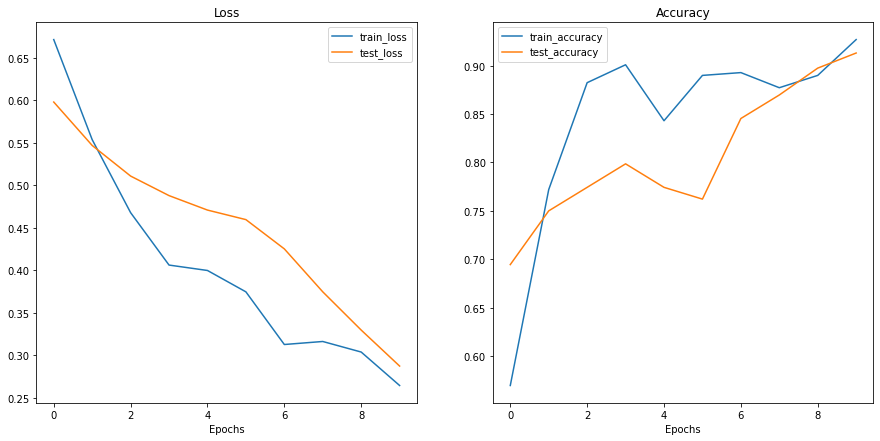

In [17]:
# Get the plot_loss_curves() function from vizz_actions.py, download the file if we don't have it
from scripts import viz_actions

# Plot the loss curves of our model
viz_actions.plot_loss_curves(results)

In [18]:
# Importing some metrics modules from sklearn that we will use to evaluate the training progress 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, r2_score

Test Accuracy: 0.92
Precision:0.8666666666666667 
Recall: 0.8666666666666667
F1 Score: 0.8666666666666667
Confusion Matrix:


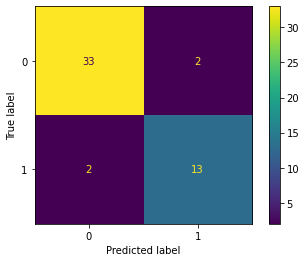

In [19]:
#Print metrics and confusion matrix
c_matrix = confusion_matrix(y_tests, y_preds)

ConfusionMatrixDisplay(c_matrix).plot()
print(f"Test Accuracy: {accuracy_score(y_tests, y_preds)}\nPrecision:{precision_score(y_tests, y_preds)} \nRecall: {recall_score(y_tests, y_preds)}\nF1 Score: {f1_score(y_tests, y_preds)}\nConfusion Matrix:")

## 6. Predict and plot some images
Lastly we take som random images from the test dataset and perfrom prediction and then visualizing the predictions.

In [20]:
#from enum import auto
from typing import List, Tuple
import os
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = auto_transforms

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))
      
    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Ground Truth: {os.path.basename(os.path.normpath(image_path.parents[0]))}\nPred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

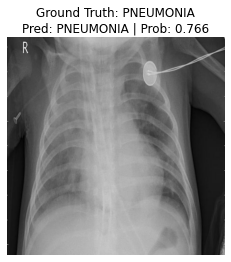

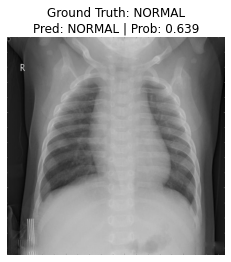

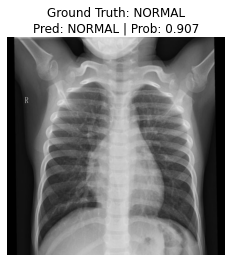

In [21]:
# Get a random list of image paths from test set
import random
import os
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    print(os.path.dirname(os.path.basename(image_path)))
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))